# Case Study Part 1

### Data Loading (CSV to Postgresql):
- users_tbl.csv -> users_tbl
- events_tbl.csv -> events_tbl
- subscriptions -> subscriptions

In [ ]:
import pandas as pd
from sqlalchemy import create_engine 
import sqlalchemy
print(sqlalchemy.__version__) # check version is 1.4.49

In [ ]:
engine = create_engine("postgresql://nicolieng@localhost:5432/nicolieng")

In [ ]:
engine.connect()

In [ ]:
# import the three CSVs separately
df = pd.read_csv('events_tbl.csv') 

In [ ]:
df.head() 

,user_id,date_calendar_connected,date_configured_location,date_first_meeting_booked,date_second_meeting_booked,date_third_meeting_booked,date_first_integrations_use,active_week_1,active_week_2,active_week_3,active_week_4
0,41283486,2025-02-10,2025-02-10,NaN,NaN,NaN,NaN,False,False,False,False
1,42559231,2025-04-08,2025-04-08,NaN,NaN,NaN,NaN,False,False,False,False
2,43670608,2025-05-22,2025-05-22,NaN,NaN,NaN,NaN,False,False,False,False
3,40458592,2025-01-04,NaN,NaN,NaN,NaN,NaN,False,False,False,False
4,43657161,2025-05-22,2025-05-22,NaN,NaN,NaN,NaN,False,False,False,False


In [ ]:
# this step is repeated for the three CSVs
print(pd.io.sql.get_schema(df, name = 'events'))

CREATE TABLE "events" (
"user_id" INTEGER,
  "date_calendar_connected" TIMESTAMP,
  "date_configured_location" TIMESTAMP,
  "date_first_meeting_booked" TIMESTAMP,
  "date_second_meeting_booked" TIMESTAMP,
  "date_third_meeting_booked" TIMESTAMP,
  "date_first_integrations_use" TIMESTAMP,
  "active_week_1" INTEGER,
  "active_week_2" INTEGER,
  "active_week_3" INTEGER,
  "active_week_4" INTEGER
)


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613490 entries, 0 to 613489
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      613490 non-null  int64         
 1   date_calendar_connected      613490 non-null  datetime64[ns]
 2   date_configured_location     518878 non-null  datetime64[ns]
 3   date_first_meeting_booked    197840 non-null  datetime64[ns]
 4   date_second_meeting_booked   160160 non-null  datetime64[ns]
 5   date_third_meeting_booked    141208 non-null  datetime64[ns]
 6   date_first_integrations_use  18085 non-null   datetime64[ns]
 7   active_week_1                613490 non-null  int64         
 8   active_week_2                613490 non-null  int64         
 9   active_week_3                613490 non-null  int64         
 10  active_week_4                613490 non-null  int64         
dtypes: datetime64[ns](6), int6

In [ ]:
#Events_tbl-data object type cleaning

df.date_calendar_connected	= pd.to_datetime(df.date_calendar_connected)
df.date_configured_location = pd.to_datetime(df.date_configured_location)
df.date_first_meeting_booked = pd.to_datetime(df.date_first_meeting_booked)
df.date_second_meeting_booked = pd.to_datetime(df.date_second_meeting_booked)
df.date_third_meeting_booked = pd.to_datetime(df.date_third_meeting_booked)
df.date_first_integrations_use = pd.to_datetime(df.date_first_integrations_use)


In [ ]:
df.to_sql(name='events',con=engine,index=False) 

490

In [ ]:
# data checking and exploration
query="""
SELECT count(distinct user_id)
 from subscriptions
;
"""

pd.read_sql(query,con=engine)

,count
0,46177


## Building User-level model:

#### For the user-level model, I will engineer the following features:

Events table: 
- days_to_configure_location, assumed to take place before activation
- days_to_first_meeting, measures speed of activation
- days_between_first_and_second_meeting, measures booking momentum
- days_between_second_and_third_meeting, measures booking momentum
- days_to_first_integration, measures time to use integration 
- meetings_in_30d, measures 30 day engagement
- perc_active_weeks_in_m1, tracks for how many weeks of the first four weeks is a user active

- First meeting within 7 days, turns 'days_to_first_meeting' into a boolean indicator for correlation purposes
- Second meeting within 7 days, turns 'days_between_first_and_second_meeting' feature into a boolean indicator for correlation purposes
- Three meetings 30d,  turns 'meetings_in_30d' into a boolean indicator for correlation purposes
- Integration used within 14 days, checks if first integration happened early 

Subscriptions table:
- is_subscribed, if users exist in subscriptions
- days to subscribe, measures time it takes from signup to subscribe
- is_first_subscription_ongoing, checks if first subscription is still ongoing
- is_renewed, if a subscription is renewed
- num_renewals, the number of renewals a user has

In [ ]:
query="""
WITH base AS (
    SELECT 
        u.user_id,
        u.signup_date,
        u.acquisition_source,
        u.account_type,
        u.country,
        u.onboarding_stage,
        CASE WHEN e.date_first_meeting_booked IS NOT NULL THEN 1 ELSE 0 END                                          AS is_activated,

        -- Event Features
        CASE WHEN e.date_configured_location IS NOT NULL THEN 1 ELSE 0 END                                           AS configured_location,
        CASE WHEN e.date_first_meeting_booked IS NOT NULL THEN 1 ELSE 0 END                                          AS booked_first_meeting,
        CASE WHEN e.date_second_meeting_booked IS NOT NULL THEN 1 ELSE 0 END                                         AS booked_second_meeting,
        CASE WHEN e.date_third_meeting_booked IS NOT NULL THEN 1 ELSE 0 END                                          AS booked_third_meeting,
        CASE WHEN e.date_first_integrations_use IS NOT NULL THEN 1 ELSE 0 END                                        AS used_first_integration, 
        date_first_meeting_booked,
        
        --Events before first meeting
        DATE_PART('day', e.date_configured_location - u.signup_date)                                                 AS days_to_configure_location,        

        -- Days to first meeting , speed of activation
        DATE_PART('day', e.date_first_meeting_booked - u.signup_date)                                                AS days_to_first_meeting,
        CASE WHEN DATE_PART('day', e.date_first_meeting_booked - u.signup_date) <= 7 THEN 1 ELSE 0 END               AS first_meeting_within_7d,       

        -- Days between meetings, momentum booking
        DATE_PART('day',e.date_second_meeting_booked - e.date_first_meeting_booked)                                  AS days_between_first_and_second_meeting,
        DATE_PART('day',e.date_third_meeting_booked - e.date_second_meeting_booked)                                  AS days_between_second_and_third_meeting,
        CASE WHEN DATE_PART('day',e.date_second_meeting_booked - e.date_first_meeting_booked) <= 7 
            THEN 1 ELSE 0 END                                                                                        AS second_meeting_within_7d,

        -- Long term engagement activity 
        CASE WHEN
        (CASE WHEN e.date_first_meeting_booked  <= u.signup_date +  Interval '30 days'  THEN 1 ELSE 0 END
         + CASE WHEN e.date_second_meeting_booked <= u.signup_date +  Interval '30 days'  THEN 1 ELSE 0 END
         + CASE WHEN e.date_third_meeting_booked  <= u.signup_date +  Interval '30 days'  THEN 1 ELSE 0 END
        ) = 3 THEN 1 ELSE 0 END                                                                                      AS three_meetings_30d,

        CASE WHEN e.date_first_meeting_booked  <= u.signup_date +  Interval '30 days'  THEN 1 ELSE 0 END
         + CASE WHEN e.date_second_meeting_booked <= u.signup_date +  Interval '30 days'  THEN 1 ELSE 0 END
         + CASE WHEN e.date_third_meeting_booked  <= u.signup_date +  Interval '30 days'  THEN 1 ELSE 0 END
                                                                                                                     AS meetings_in_30d,
        
        --Activity in early weeks 
        round((active_week_1::INTEGER + active_week_2::INTEGER + 
            active_week_3::INTEGER + active_week_4::INTEGER)/4.0,2)                                                  AS perc_active_weeks_in_m1,

        -- Integrations flag
        DATE_PART('day',e.date_first_integrations_use - u.signup_date)                                               AS days_to_first_integration,
        CASE WHEN e.date_first_integrations_use <= u.signup_date + Interval '14 days' THEN 1 ELSE 0 END              AS integration_within_14d,
        e.date_first_integrations_use

    FROM users_tbl u
    LEFT JOIN events e
        ON u.user_id = e.user_id
),

sub_agg AS ( 
    SELECT
        user_id,
        subscription_currency_code,	
        subscription_billing_cycle,	
        subscription_plan_type,
        MIN(subscription_start_date)                                                                                AS first_subscription_date
    FROM subscriptions 
    WHERE subscription_event_type = 'subscription_created'
        GROUP BY user_id, subscription_currency_code, subscription_billing_cycle, subscription_plan_type
),

sub_renewals AS (
    SELECT
        user_id,
        subscription_currency_code,	
        subscription_billing_cycle,	
        subscription_plan_type,
        subscription_start_date,
        subscription_event_type,
        ROW_NUMBER() OVER (PARTITION BY user_id, subscription_currency_code, 
            subscription_billing_cycle, subscription_plan_type ORDER BY subscription_start_date DESC)               AS rn
    FROM subscriptions
        WHERE subscription_event_type = 'subscription_renewed'
),

latest_sub AS (
    SELECT
        user_id, 
        subscription_plan_type,
        subscription_currency_code,	
        subscription_billing_cycle,	
        subscription_start_date AS latest_subscription_date,
        subscription_event_type AS latest_subscription_event,
        CASE WHEN subscription_event_type like 'subscription_renewed' THEN 1 ELSE 0 END AS is_renewed
    FROM sub_renewals
        WHERE rn = 1 
),

sub_renewal_history AS( 
    SELECT
        user_id,
        subscription_currency_code,	
        subscription_billing_cycle,	
        subscription_plan_type,
        COUNT(CASE WHEN subscription_event_type = 'subscription_renewed' THEN 1 END )                   AS num_renewals
    FROM subscriptions 
        GROUP BY user_id, subscription_currency_code, subscription_billing_cycle, subscription_plan_type
)

SELECT
    b.*,
    CASE WHEN sa.user_id IS NOT NULL THEN 1 ELSE 0 END                                                  AS is_subscribed,
    DATE_PART('day', sa.first_subscription_date - b.signup_date)                                        AS days_to_subscribe,
    sa.first_subscription_date,
    CASE WHEN sa.subscription_billing_cycle = 'monthly' 
            AND sa.first_subscription_date + Interval '30 days' >= DATE('2025-08-01') THEN 1 
        WHEN sa.subscription_billing_cycle = 'yearly' 
            AND sa.first_subscription_date + Interval '365 days' >= DATE('2025-08-01') THEN 1 
        ELSE 0 
        END                                                                                             AS is_first_subscription_ongoing,
    s.latest_subscription_date,
    COALESCE( s.is_renewed, 0)                                                                          AS is_renewed,
    num_renewals,
    sa.subscription_currency_code,
    sa.subscription_plan_type,
    sa.subscription_billing_cycle
FROM base b
LEFT JOIN sub_agg sa
    ON b.user_id = sa.user_id
LEFT JOIN latest_sub s 
    ON sa.user_id = s.user_id and sa.subscription_plan_type = s.subscription_plan_type and sa.subscription_currency_code = s.subscription_currency_code and sa.subscription_billing_cycle = s.subscription_billing_cycle
LEFT JOIN sub_renewal_history sh
    ON sa.user_id = sh.user_id and sa.subscription_plan_type = sh.subscription_plan_type and sa.subscription_currency_code = sh.subscription_currency_code and sa.subscription_billing_cycle = s.subscription_billing_cycle
    ORDER BY b.user_id


;
"""
result = pd.read_sql(query,con=engine)

KeyboardInterrupt: 

In [490]:
result.to_csv('user_model.csv', index = False)

### Loading new user-level model into Postgresql

In [644]:
df = pd.read_csv('user_model.csv') 
df.head()

,user_id,signup_date,acquisition_source,account_type,country,onboarding_stage,is_activated,configured_location,booked_first_meeting,booked_second_meeting,booked_third_meeting,used_first_integration,date_first_meeting_booked,days_to_configure_location,days_to_first_meeting,first_meeting_within_7d,days_between_first_and_second_meeting,days_between_second_and_third_meeting,second_meeting_within_7d,three_meetings_30d,meetings_in_30d,perc_active_weeks_in_m1,days_to_first_integration,integration_within_14d,date_first_integrations_use,is_subscribed,days_to_subscribe,first_subscription_date,is_first_subscription_ongoing,latest_subscription_date,is_renewed,num_renewals,subscription_currency_code,subscription_plan_type,subscription_billing_cycle
0,40402082,2025-01-01,Brand Marketing,Business,US,completed,0,1,0,0,0,0,NaN,0.0,NaN,0,NaN,NaN,0,0,0,0.00,NaN,0,NaN,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN
1,40402085,2025-01-01,Website,Business,US,completed,1,1,1,1,1,0,2025-02-06,16.0,36.0,0,1.0,0.0,1,0,0,0.00,NaN,0,NaN,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN
2,40402101,2025-01-01,Calendly Booking Link,Personal,US,completed,0,1,0,0,0,0,NaN,0.0,NaN,0,NaN,NaN,0,0,0,0.00,NaN,0,NaN,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN
3,40402106,2025-01-01,Calendly Booking Link,Personal,US,completed,0,1,0,0,0,0,NaN,0.0,NaN,0,NaN,NaN,0,0,0,0.00,NaN,0,NaN,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN
4,40402116,2025-01-01,Calendly Booking Link,Personal,US,completed,0,1,0,0,0,0,NaN,0.0,NaN,0,NaN,NaN,0,0,0,0.25,NaN,0,NaN,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN


In [ ]:
print(pd.io.sql.get_schema(df, name = 'user_model_3'))

CREATE TABLE "user_model" (
"user_id" INTEGER,
  "signup_date" TEXT,
  "acquisition_source" TEXT,
  "account_type" TEXT,
  "country" TEXT,
  "onboarding_stage" TEXT,
  "is_activated" INTEGER,
  "configured_location" INTEGER,
  "booked_first_meeting" INTEGER,
  "booked_second_meeting" INTEGER,
  "booked_third_meeting" INTEGER,
  "used_first_integration" INTEGER,
  "date_first_meeting_booked" TEXT,
  "days_to_configure_location" REAL,
  "days_to_first_meeting" REAL,
  "first_meeting_within_7d" INTEGER,
  "days_between_first_and_second_meeting" REAL,
  "days_between_second_and_third_meeting" REAL,
  "second_meeting_within_7d" INTEGER,
  "three_meetings_30d" INTEGER,
  "meetings_in_30d" INTEGER,
  "perc_active_weeks_in_m1" REAL,
  "days_to_first_integration" REAL,
  "integration_within_14d" INTEGER,
  "date_first_integrations_use" TEXT,
  "is_subscribed" INTEGER,
  "days_to_subscribe" REAL,
  "first_subscription_date" TEXT,
  "is_first_subscription_ongoing" INTEGER,
  "latest_subscription_

In [493]:
df.signup_date	= pd.to_datetime(df.signup_date)
df.first_subscription_date = pd.to_datetime(df.first_subscription_date)
df.latest_subscription_date = pd.to_datetime(df.latest_subscription_date)

In [494]:
df.to_sql(name='user_model_3',con=engine,index=False) 

572

In [639]:
# Benchmark gathering 
query="""
SELECT avg(days_to_configure_location),
        avg(days_to_first_meeting), 
        avg(days_between_first_and_second_meeting),
        avg (days_to_first_integration),
        avg(days_to_subscribe)
FROM user_model_3
;
"""

pd.read_sql(query,con=engine)

,avg,avg,avg,avg,avg
0,1.599522,12.98082,7.098923,14.530858,25.700143


### Q1: What behavioral patterns seem to differentiate users who activate vs those who do not? 
###### Hypothesis 1 : Business users have regular meetings with many people, they have a need for scheduling (compared to non-business user)
###### Hypothesis 2 : The more guidance during onboarding, the more likley someone learns the tool and use it.
###### Hypothesis 3 : People who configured location are ready to book their first meeting. 

In [471]:
query="""
SELECT ACCOUNT_TYPE, sum(is_activated)/count(1) as activation_rate,  count(1) as total_signups
FROM user_model_2
GROUP BY 1 ;
 ;
"""

pd.read_sql(query,con=engine)

,account_type,activation_rate,total_signups
0,Business,0.496973,275999
1,Personal,0.179976,337573


In [613]:
query="""
SELECT acquisition_source, sum(is_activated)/count(1) as activation_rate,  count(1) as total_signups
FROM user_model_3
GROUP BY 1  
;
"""
#US activation is a little lower compared to AU and GB. but likely due to higher total signups

pd.read_sql(query,con=engine)

,acquisition_source,activation_rate,total_signups
0,Brand Marketing,0.496627,150481
1,Calendly Booking Link,0.208023,350596
2,Sales,0.762400,9718
3,Website,0.416873,102777


In [ ]:
# test hypothesis 3
query="""
SELECT configured_location, sum(is_activated)/count(1) as activation_rate
FROM user_model_3
GROUP BY 1 ;
;
"""

pd.read_sql(query,con=engine)

,configured_location,activation_rate
0,0,0.060130
1,1,0.370414


In [495]:
pd.set_option('display.width', None) # Displays all columns without truncation
pd.set_option('display.max_columns', None)

query="""
SELECT *
FROM user_model_3
limit 1 ;
 ;
"""

pd.read_sql(query,con=engine)

,user_id,signup_date,acquisition_source,account_type,country,onboarding_stage,is_activated,configured_location,booked_first_meeting,booked_second_meeting,booked_third_meeting,used_first_integration,date_first_meeting_booked,days_to_configure_location,days_to_first_meeting,first_meeting_within_7d,days_between_first_and_second_meeting,days_between_second_and_third_meeting,second_meeting_within_7d,three_meetings_30d,meetings_in_30d,perc_active_weeks_in_m1,days_to_first_integration,integration_within_14d,date_first_integrations_use,is_subscribed,days_to_subscribe,first_subscription_date,is_first_subscription_ongoing,latest_subscription_date,is_renewed,num_renewals,subscription_currency_code,subscription_plan_type,subscription_billing_cycle
0,40402082,2025-01-01,Brand Marketing,Business,US,completed,0,1,0,0,0,0,None,0.0,None,0,None,None,0,0,0,0.0,None,0,None,0,None,None,0,None,0,None,None,None,None


### Q2: What early user actions appear to correlate with longer engagement or subscription likelihood?  
###### Hypothesis 1 : Users who make their first booking with 7 days of signup are more likely to remain engaged long term 
###### Hypothesis 2 : Similarly to the first hypothesis, users who set up their second meeting within 7 days from the first meeting are more likely to realize value and engage long-term.
###### Hypothesis 3 : Users who have made 3 meetings in the first 30 days are likely to subscribe (high booking volume reflects scheduling needs and recursive cadence
###### Hypothesis 4 : Users who use integration early (within 14 days) are more likely to stay/ subscribe.

In [ ]:
# hypothesis 1
query="""
SELECT first_meeting_within_7d, sum(is_subscribed)/count(1) as subscription_rate
FROM user_model_2
group by 1 
 ;
"""

pd.read_sql(query,con=engine)

,first_meeting_within_7d,?column?
0,0,0.027184
1,1,0.124790


In [ ]:
# Second meeting within 7d tells us more about subscription rate (regardless of whether first meeting is booked within 7 days of signup)
# This shows that momentum is "worth more" than early starters.

query="""
SELECT first_meeting_within_7d, second_meeting_within_7d , sum(is_subscribed)/count(1) as subscription_rate
FROM user_model_2
group by 1,2
 ;
"""

pd.read_sql(query,con=engine)

,first_meeting_within_7d,second_meeting_within_7d,subscription_rate
0,0,0,0.016192
1,0,1,0.166219
2,1,0,0.090160
3,1,1,0.140527


In [529]:
# Meeting momentum and integration together is a even stronger predictor of subscription likelihood.
query="""

SELECT second_meeting_within_7d, integration_within_14d, sum(is_subscribed)/count(1) 
FROM user_model_2
group by 1,2
 ;
"""

pd.read_sql(query,con=engine)

,second_meeting_within_7d,integration_within_14d,?column?
0,0,0,0.021615
1,0,1,0.101726
2,1,0,0.142264
3,1,1,0.235947


In [641]:
# hypothesis 4

query="""
SELECT integration_within_14d, sum(is_subscribed)/count(1) as subscription_rate
FROM user_model_3
group by 1
 ;
"""

pd.read_sql(query,con=engine)

,integration_within_14d,subscription_rate
0,0,0.046044
1,1,0.172351


In [592]:
# Segment analysis: Business accounts have relatively good booking momentum
query="""
SELECT account_type, sum(second_meeting_within_7d)/count(1), count(1) as total
FROM user_model_3
group by 1 
 ;
"""

pd.read_sql(query,con=engine)

,account_type,?column?,count
0,Business,0.314253,256427
1,Personal,0.088965,327164


In [618]:
# Current subscription rate
query="""
SELECT account_type, sum(is_subscribed)/count(1) as subscription_rate
FROM user_model_3
group by 1
;
"""
pd.read_sql(query,con=engine)

,account_type,?column?
0,Business,0.070913
1,Personal,0.030835


In [581]:
# Who's struggling with integration ? --Segmentation
# Account type: Personal account
# Acquisition source: Calendly Booking Link 
# Country: fairly equal
# billing_cycle: monthly subscriptions


query="""
SELECT account_type, sum(integration_within_14d)/count(1), count(1) as total_signups
FROM user_model_3
group by 1
 ;
"""

pd.read_sql(query,con=engine)

,account_type,?column?,count
0,Business,0.036428,275999
1,Personal,0.010780,337573


In [596]:
# Who's struggling with rapid booking ? --Segmentation
# Account type: Personal account
# Acquisition source: Calendly Booking Link 
# Country: US
# billing_cycle: pretty equal


query="""
SELECT  sum(configured_location)/count(1), count(1)
FROM user_model_3
group by 1
 ;
"""

pd.read_sql(query,con=engine)

,account_type,?column?,count
0,Business,0.961929,137164
1,Personal,0.992313,60755


In [ ]:
# hypothesis 3
# note this variable is highly correlatied with perc_active_weeks_in_m1

query="""
SELECT meetings_in_30d, sum(is_subscribed)/count(1) as subscription_rate
FROM user_model_3
group by 1
 ;
"""

pd.read_sql(query,con=engine)

,meetings_in_30d,subscription_rate
0,0,0.016912
1,1,0.077447
2,2,0.107109
3,3,0.156251


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Load dataset
df = pd.read_csv("user_model.csv")

feature_cols = [
    "first_meeting_within_7d",
    "second_meeting_within_1d",
    "three_meetings_30d",
    "integration_within_14d",
    "meetings_in_30d",
]
X = df[feature_cols]
y = df["is_subscribed"]  # your target variable

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Coefficients
coefficients = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Logistic Coefficients):\n", coefficients)


Multicollinearity check (VIF)

###### meetings_in_30d: 16.1 → high collinearity (commonly concerning if >10).
###### three_meetings_30d: 8.4 → moderate collinearity.

### Logistic regression results

| Predictor                  | Coefficient | Interpretation                                                           |
| -------------------------- | ----------- | ------------------------------------------------------------------------ |
| `first_meeting_within_7d`  | **-0.17**   | Slightly decreases subscription likelihood.                              |
| `second_meeting_within_7d` | **+0.54**   | Increases likelihood.                                                    |
| `three_meetings_30d`       | **-0.90**   | Strongly decreases likelihood (but may be collinear with meeting count). |
| `integration_within_14d`   | **+0.76**   | Strong positive predictor.                                               |
| `meetings_in_30d`          | **+0.93**   | Strong positive predictor.                                               |


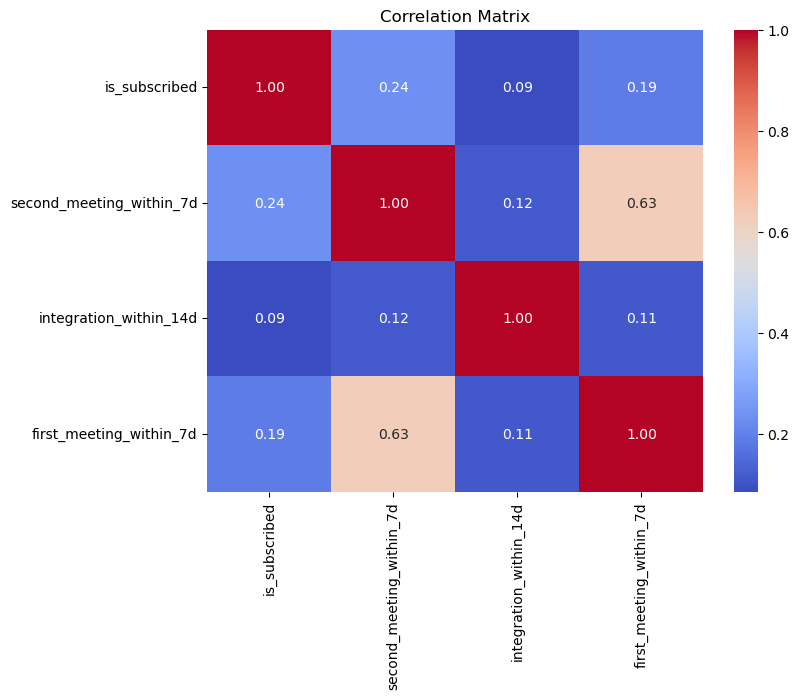

In [645]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_use = ['is_subscribed', 'second_meeting_within_7d', 'integration_within_14d', 'first_meeting_within_7d']  # replace with your actual column names

# Compute correlation matrix for selected columns
corr = df[columns_to_use].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

